# Simple Linear Regression With OLS

In [1]:
import helpers as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

## Load Data
Load the dataset and inspect it's contents.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## Missing Values
### Variable types
Create lists of continuous and categorical data.

In [7]:
cont_variables, cat_variables = hp.find_variable_types(df)

In [8]:
print(f'Continuous variables:\n{cont_variables}\n')
print(f'Categorical variables:\n{cat_variables}')

Continuous variables:
['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']

Categorical variables:
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'function

Remove `'id'` column from `cont_variables` since this column isn't a variable.

In [9]:
cont_variables.remove('id')

In [10]:
print(cont_variables)

['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']


### Unique categories
Print unique categories.

In [11]:
hp.print_unique_categories(df, cat_variables)

mszoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
street: ['Pave' 'Grvl']
alley: [None 'Grvl' 'Pave']
lotshape: ['Reg' 'IR1' 'IR2' 'IR3']
landcontour: ['Lvl' 'Bnk' 'Low' 'HLS']
utilities: ['AllPub' 'NoSeWa']
lotconfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
landslope: ['Gtl' 'Mod' 'Sev']
neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
bldgtype: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
housestyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
roofstyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
roofmatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
exterior1st: ['V

### Missing categories
The missing category columns are labeled at `None`. I will replace these with `"None"`.

In [12]:
df_clean = hp.fill_missing_categories(df, cat_variables)

In [13]:
df_clean.loc[:, cat_variables].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
mszoning         1460 non-null object
street           1460 non-null object
alley            1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1460 non-null object
exterqual        1460 non-null object
extercond        1460 non-null object
foundation       1460 non-null object
bsmtqual         1460 non-null object
bsmtcond         1460 non-null object
bsmtexposure     14

### Missing value fractions

In [14]:
hp.find_na_columns(df_clean, display_fractions=True)

lotfrontage    17.739726
masvnrarea      0.547945
garageyrblt     5.547945
dtype: float64


In [15]:
na_fractions = hp.find_na_columns(df_clean)

In [16]:
df_clean.loc[:, na_fractions.index].describe().T

,count,mean,std,min,25%,50%,75%,max
lotfrontage,1201.0,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
masvnrarea,1452.0,103.685262,181.066207,0.0,0.0,0.0,166.0,1600.0
garageyrblt,1379.0,1978.506164,24.689725,1900.0,1961.0,1980.0,2002.0,2010.0


Handling each case separately.

#### `'lotfrontage'`
* Fill missing values with zeros.

In [17]:
df_clean['lotfrontage'].fillna(value=0, inplace=True)

#### `'masvnarea'`
* Fill missing values with zeros.

In [18]:
df_clean['masvnrarea'].fillna(value=0, inplace=True)

#### `'garageyrblt'`
* Drop all properties that do not have a garage.
    
    Note: This will remove roughly 5% of the values.

In [19]:
df_clean.loc[df['garagetype'] == 'None', 'garageyrblt'].unique()

array([nan])

In [20]:
df_clean.dropna(inplace=True)
df_clean.index = np.arange(len(df_clean))

In [21]:
hp.find_na_columns(df_clean, display_fractions=True)

Series([], dtype: float64)


All missing values have now been dealt with.

In [22]:
print(f'The dataset size is now {len(df_clean)}.')

The dataset size is now 1379.


In [23]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1379.0,731.879623,421.059059,1.0,366.5,734.0,1094.5,1460.0
mssubclass,1379.0,56.022480,41.026897,20.0,20.0,50.0,70.0,190.0
lotfrontage,1379.0,57.766497,35.038221,0.0,41.5,64.0,79.0,313.0
lotarea,1379.0,10695.812183,10214.702133,1300.0,7741.0,9591.0,11708.5,215245.0
overallqual,1379.0,6.187092,1.345780,2.0,5.0,6.0,7.0,10.0
overallcond,1379.0,5.577955,1.081031,2.0,5.0,5.0,6.0,9.0
yearbuilt,1379.0,1972.958666,29.379883,1880.0,1955.0,1976.0,2001.0,2010.0
yearremodadd,1379.0,1985.435098,20.444852,1950.0,1968.0,1994.0,2004.0,2010.0
masvnrarea,1379.0,108.364757,184.195220,0.0,0.0,0.0,170.5,1600.0
bsmtfinsf1,1379.0,455.578680,459.691379,0.0,0.0,400.0,732.0,5644.0


In [74]:
df_clean.corr()['saleprice_bc_tk'].sort_values()

kitchenabvgr_sd       -0.159965
kitchenabvgr          -0.159965
overallcond_tk        -0.089710
overallcond_tk_sd     -0.089710
mssubclass            -0.069786
overallcond           -0.064014
yrsold                -0.036097
id                    -0.026351
mssubclass_bc         -0.005622
mssubclass_bc_sd      -0.005622
mosold_sd              0.058573
mosold                 0.058573
secondflrsf_bc         0.162788
secondflrsf_bc_sd      0.162788
lotfrontage_tk         0.178699
lotfrontage_tk_sd      0.178699
lotfrontage            0.179069
bedroomabvgr           0.199387
bsmtunfsf_bc           0.213329
bsmtunfsf_bc_sd        0.213329
bedroomabvgr_tk_sd     0.213683
bedroomabvgr_tk        0.213683
bsmtunfsf              0.224229
bsmtfinsf1_bc          0.228944
bsmtfullbath           0.238419
bsmtfullbath_sd        0.238419
lotarea                0.245425
halfbath_sd            0.303914
halfbath               0.303914
secondflrsf            0.310446
                         ...   
totrmsab

#### Mostly Zeros
If 75% of the variables values are zero, remove that variable. That variable would add too little information to the model.

In [24]:
df_described = df_clean.describe().T

In [25]:
mostly_zeros = df_described[df_described['75%'] == 0.0].index.tolist()

In [26]:
print(f'The columns that contain mostly zero values are:\n{mostly_zeros}')

The columns that contain mostly zero values are:
['bsmtfinsf2', 'lowqualfinsf', 'bsmthalfbath', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval']


Drop mostly zero columns.

In [27]:
df_clean.drop(columns=mostly_zeros, inplace=True)

In [28]:
print(f'The dataset now contains {len(df_clean.columns)} columns.')

The dataset now contains 73 columns.


Update `cont_variables` list.

In [29]:
cont_variables = [x for x in cont_variables if x not in mostly_zeros]

### Outliers
#### Year columns
Split continous variables into year variables and other continous variables.

In [76]:
df_clean.loc[:, year_columns].describe().T
# Convert years into dummies if it can be
# Chi-squared test on years built

,count,mean,std,min,25%,50%,75%,max
garageyrblt,1379.0,1978.506164,24.689725,1900.0,1961.0,1980.0,2002.0,2010.0
yearremodadd,1379.0,1985.435098,20.444852,1950.0,1968.0,1994.0,2004.0,2010.0
yearbuilt,1379.0,1972.958666,29.379883,1880.0,1955.0,1976.0,2001.0,2010.0
yrsold,1379.0,2007.812183,1.330221,2006.0,2007.0,2008.0,2009.0,2010.0


In [30]:
year_columns = ['garageyrblt', 'yearremodadd', 'yearbuilt', 'yrsold']
cont_variables = [x for x in cont_variables if x not in year_columns]

In [31]:
df_clean.loc[:, cont_variables].describe().T.sort_values(by='max')

,count,mean,std,min,25%,50%,75%,max
bsmtfullbath,1379.0,0.430747,0.514052,0.0,0.0,0.0,1.0,2.0
halfbath,1379.0,0.395939,0.502402,0.0,0.0,0.0,1.0,2.0
fireplaces,1379.0,0.641769,0.645985,0.0,0.0,1.0,1.0,3.0
kitchenabvgr,1379.0,1.038434,0.196048,1.0,1.0,1.0,1.0,3.0
fullbath,1379.0,1.580131,0.548051,0.0,1.0,2.0,2.0,3.0
garagecars,1379.0,1.870921,0.630055,1.0,1.0,2.0,2.0,4.0
bedroomabvgr,1379.0,2.865120,0.783961,0.0,2.0,3.0,3.0,6.0
overallcond,1379.0,5.577955,1.081031,2.0,5.0,5.0,6.0,9.0
overallqual,1379.0,6.187092,1.345780,2.0,5.0,6.0,7.0,10.0
totrmsabvgrd,1379.0,6.552574,1.589821,3.0,5.0,6.0,7.0,12.0


Because of the large spread in values for the different variables, it will be hard to look at all variables at once to determine how to handle their outliers. Therefore, I will split that `DataFrame` into three parts, split by their max values.

In [32]:
df_described = df_clean.loc[:, cont_variables].describe().T

In [33]:
df_described_small = df_described.loc[df_described['max'] < 100, :].copy()
df_described_medium = df_described.loc[(df_described['max'] > 100) & (df_described['max'] < 10000), :].copy()
df_described_large = df_described.loc[df_described['max'] > 10000, :].copy()

##### Small max values

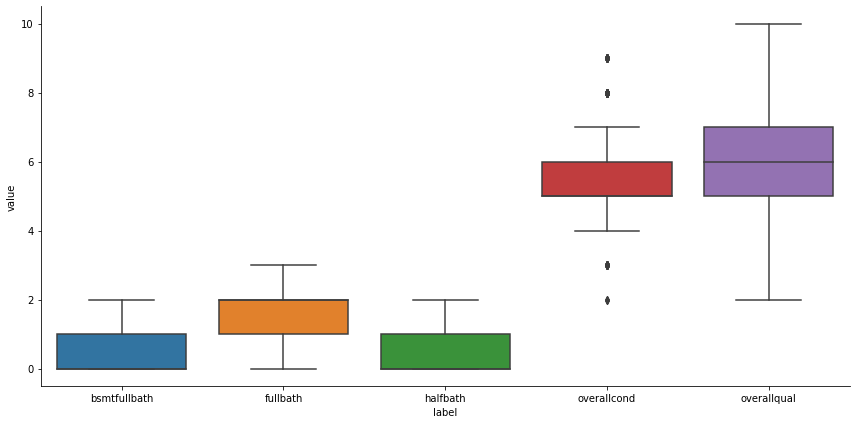

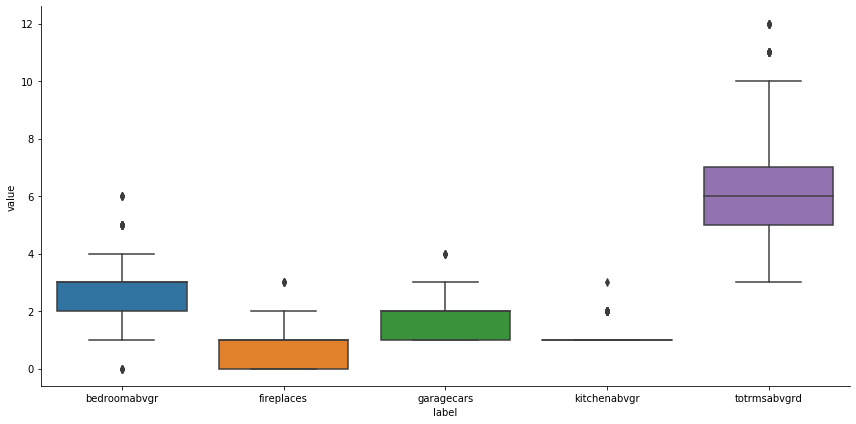

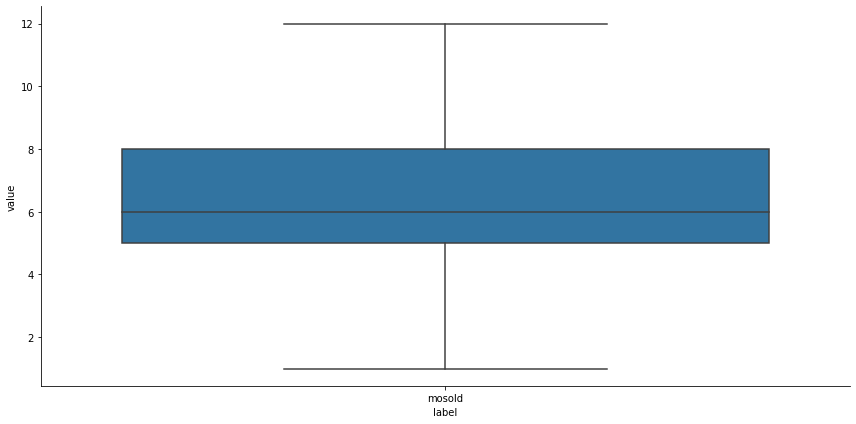

In [34]:
hp.look_for_outliers(df_clean, df_described_small.index.tolist(), max_boxes=5)

In [35]:
df_described_small.index.tolist()

['overallqual',
 'overallcond',
 'bsmtfullbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garagecars',
 'mosold']

In [36]:
# Correct outliers using Tukey method
tukey_vars_small = ['overallcond', 'bedroomabvgr', 'fireplaces', 'garagecars', 'totrmsabvgrd']
tk_corrected_small = [f'{x}_tk' for x in tukey_vars_small]
df_clean = hp.correct_outliers(df_clean, tukey_vars_small)

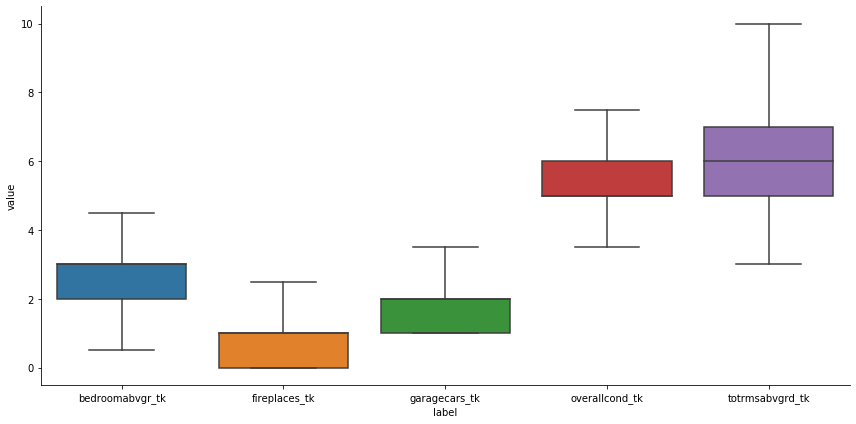

In [37]:
hp.look_for_outliers(df_clean, tk_corrected_small, max_boxes=5)

##### Medium max values

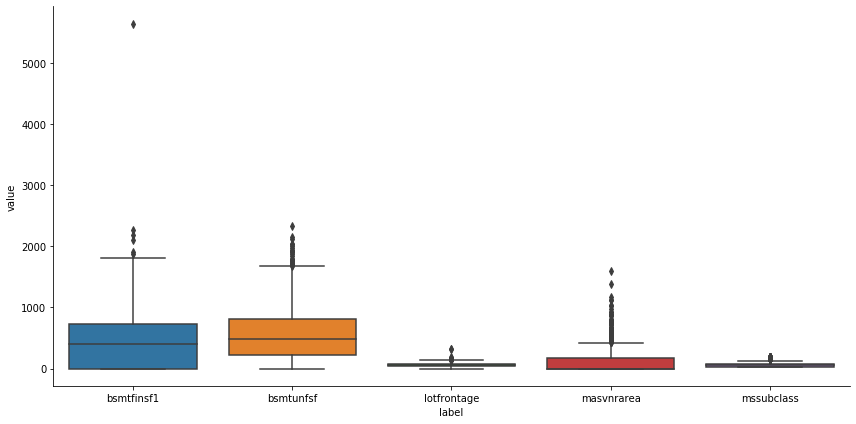

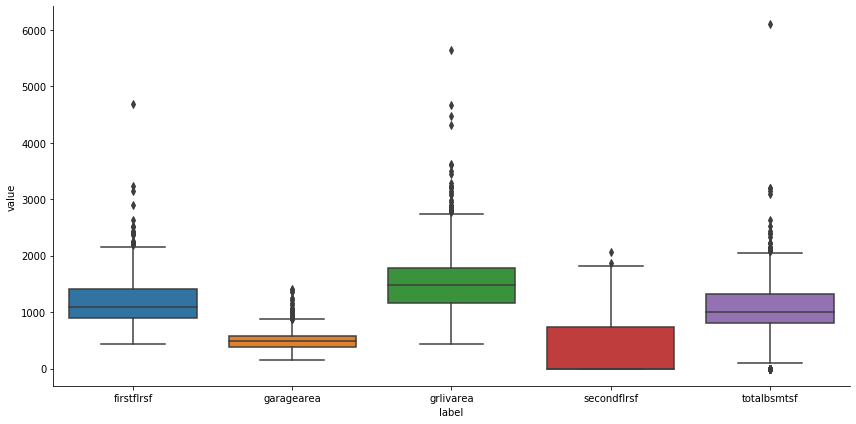

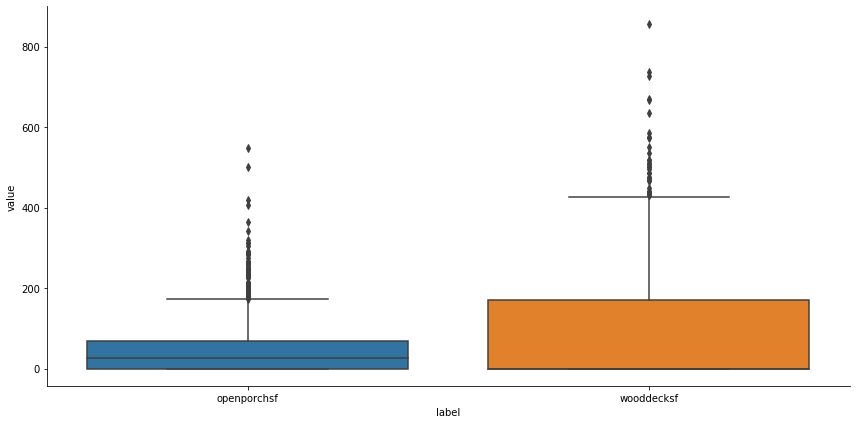

In [38]:
hp.look_for_outliers(df_clean, df_described_medium.index.tolist(), max_boxes=5)

In [39]:
df_described_medium.index.tolist()

['mssubclass',
 'lotfrontage',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'grlivarea',
 'garagearea',
 'wooddecksf',
 'openporchsf']

In [40]:
# Transform non-normal variables using Box-Cox to make them more normal
boxcox_vars_medium = ['bsmtfinsf1', 'bsmtunfsf', 'masvnrarea', 'mssubclass', 'firstflrsf', 'secondflrsf', 'grlivarea', 
                      'garagearea', 'wooddecksf', 'openporchsf']
bc_vars_transformed_medium = [f'{x}_bc' for x in boxcox_vars_medium]

In [41]:
df_clean = hp.apply_boxcox_transform(df_clean, boxcox_vars_medium)

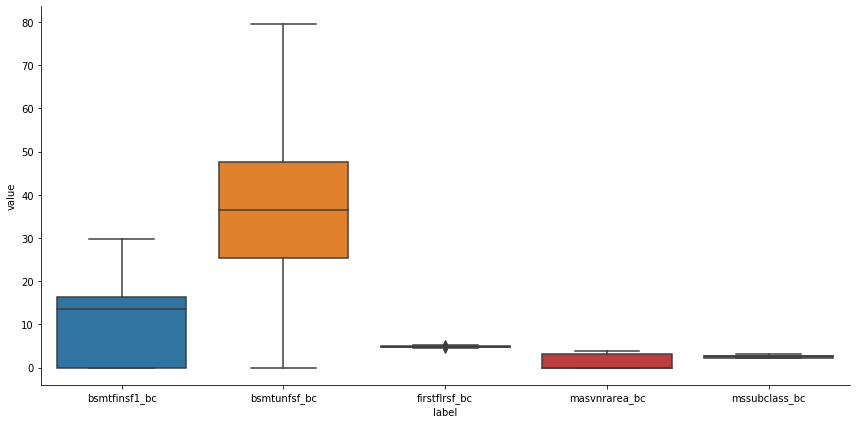

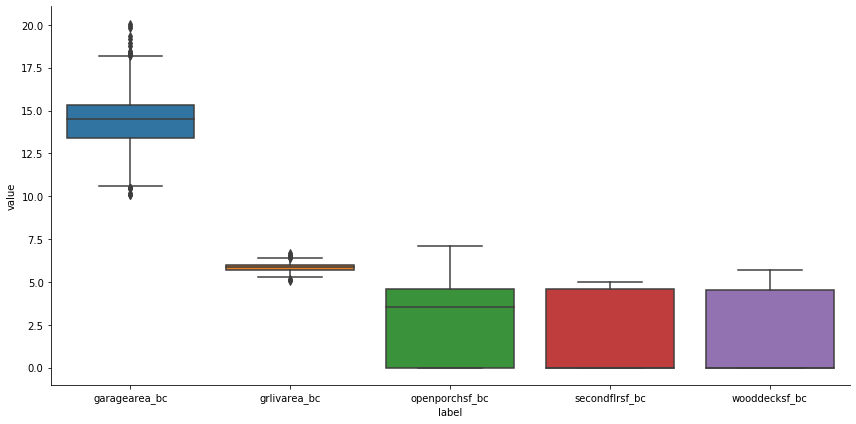

In [42]:
hp.look_for_outliers(df_clean, bc_vars_transformed_medium, max_boxes=5)

In [43]:
# Correct for outliers using Tukey method
tukey_vars_medium = ['lotfrontage', 'garagearea_bc', 'grlivarea_bc', 'totalbsmtsf']
tk_corrected_medium = [f'{x}_tk' for x in tukey_vars_medium]
df_clean = hp.correct_outliers(df_clean, tukey_vars_medium)

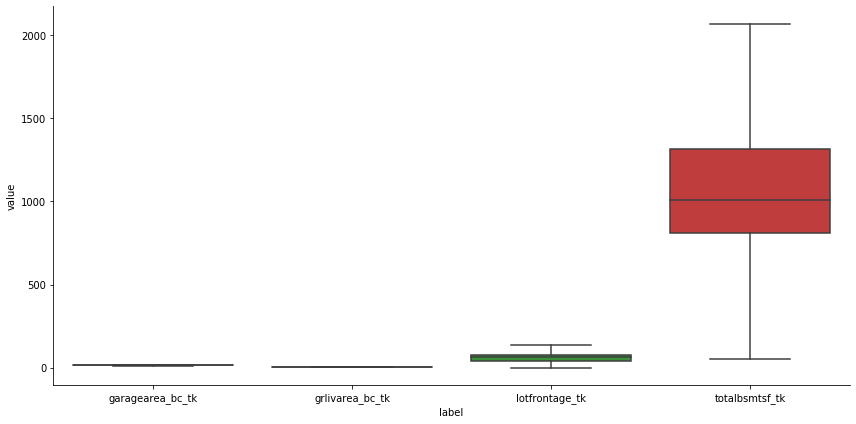

In [44]:
hp.look_for_outliers(df_clean, tk_corrected_medium, max_boxes=5)

##### Large max values

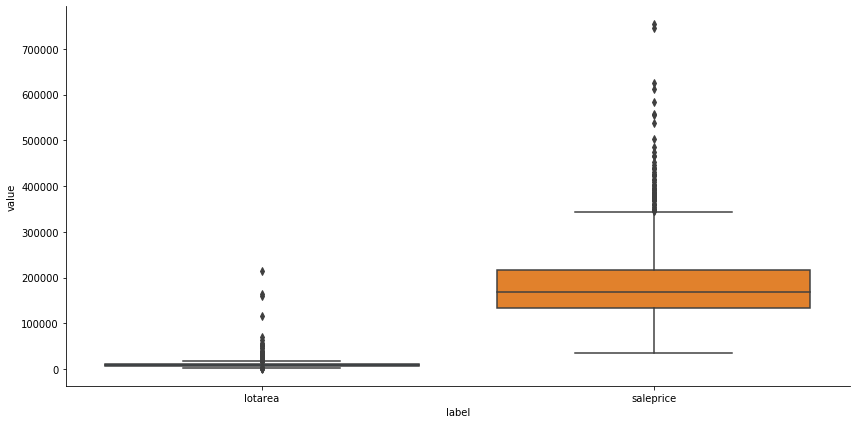

In [45]:
hp.look_for_outliers(df_clean, df_described_large.index.tolist(), max_boxes=5)

In [46]:
# Transform non-normal variables using Box-Cox to make them more normal
boxcox_vars_large = ['lotarea', 'saleprice']
bc_vars_transformed_large = ['lotarea_bc', 'saleprice_bc']

In [47]:
df_clean = hp.apply_boxcox_transform(df_clean, boxcox_vars_large)

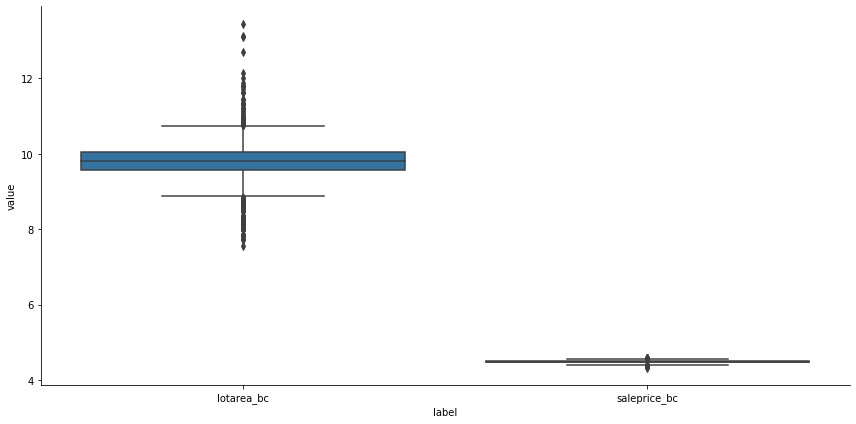

In [48]:
hp.look_for_outliers(df_clean, bc_vars_transformed_large, max_boxes=5)

In [49]:
# Correct for outliers using Tukey method
tukey_vars_large = ['lotarea_bc', 'saleprice_bc']
tk_corrected_large = [f'{x}_tk' for x in tukey_vars_large]
df_clean = hp.correct_outliers(df_clean, tukey_vars_large)

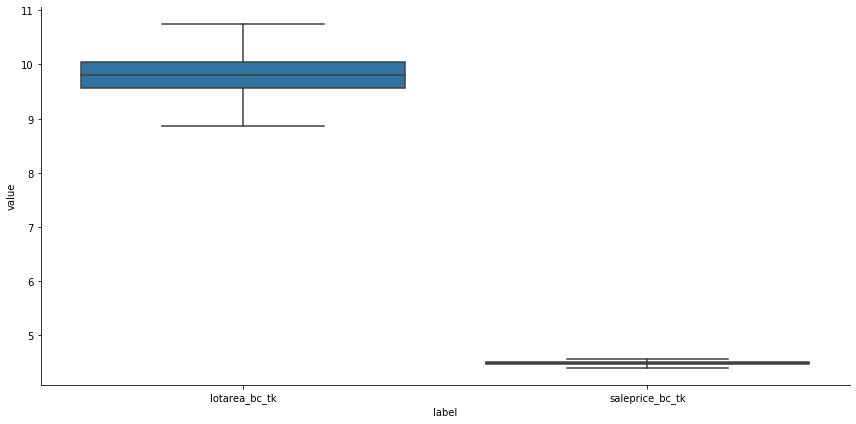

In [50]:
hp.look_for_outliers(df_clean, tk_corrected_large, max_boxes=5)

In [51]:
cont_variables.sort()
print(cont_variables)

['bedroomabvgr', 'bsmtfinsf1', 'bsmtfullbath', 'bsmtunfsf', 'fireplaces', 'firstflrsf', 'fullbath', 'garagearea', 'garagecars', 'grlivarea', 'halfbath', 'kitchenabvgr', 'lotarea', 'lotfrontage', 'masvnrarea', 'mosold', 'mssubclass', 'openporchsf', 'overallcond', 'overallqual', 'saleprice', 'secondflrsf', 'totalbsmtsf', 'totrmsabvgrd', 'wooddecksf']


In [52]:
all_variables = df_clean.columns.tolist()
all_variables.sort()
print(all_variables)

['alley', 'bedroomabvgr', 'bedroomabvgr_tk', 'bldgtype', 'bsmtcond', 'bsmtexposure', 'bsmtfinsf1', 'bsmtfinsf1_bc', 'bsmtfintype1', 'bsmtfintype2', 'bsmtfullbath', 'bsmtqual', 'bsmtunfsf', 'bsmtunfsf_bc', 'centralair', 'condition1', 'condition2', 'electrical', 'extercond', 'exterior1st', 'exterior2nd', 'exterqual', 'fence', 'fireplacequ', 'fireplaces', 'fireplaces_tk', 'firstflrsf', 'firstflrsf_bc', 'foundation', 'fullbath', 'functional', 'garagearea', 'garagearea_bc', 'garagearea_bc_tk', 'garagecars', 'garagecars_tk', 'garagecond', 'garagefinish', 'garagequal', 'garagetype', 'garageyrblt', 'grlivarea', 'grlivarea_bc', 'grlivarea_bc_tk', 'halfbath', 'heating', 'heatingqc', 'housestyle', 'id', 'kitchenabvgr', 'kitchenqual', 'landcontour', 'landslope', 'lotarea', 'lotarea_bc', 'lotarea_bc_tk', 'lotconfig', 'lotfrontage', 'lotfrontage_tk', 'lotshape', 'masvnrarea', 'masvnrarea_bc', 'masvnrtype', 'miscfeature', 'mosold', 'mssubclass', 'mssubclass_bc', 'mszoning', 'neighborhood', 'openporch

Select the columns to use as features going foward.

In [53]:
cont_variables_transformed = ['bedroomabvgr_tk', 'bsmtfinsf1', 'bsmtfullbath', 'bsmtunfsf_bc', 'fireplaces_tk', 'firstflrsf_bc', 
                              'fullbath', 'garagearea_bc_tk', 'garagecars_tk', 'grlivarea_bc_tk', 'halfbath', 'kitchenabvgr', 
                              'lotarea_bc_tk', 'lotfrontage_tk', 'masvnrarea_bc', 'mosold', 'mssubclass_bc', 'openporchsf_bc', 
                              'overallcond_tk', 'overallqual', 'secondflrsf_bc', 'totalbsmtsf_tk', 'totrmsabvgrd_tk', 
                              'wooddecksf_bc', 'saleprice_bc_tk']

### Standardization
Standardize continous variables.

In [54]:
standardized_variables = [f'{x}_sd' for x in cont_variables_transformed]
df_clean = hp.standardize(df_clean, cont_variables_transformed)

In [55]:
df_clean.loc[:, standardized_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomabvgr_tk_sd,1379.0,8.244151e-17,1.0,-3.168643,-1.150682,0.194626,0.194626,2.212587
bsmtfinsf1_sd,1379.0,1.545778e-17,1.0,-0.991053,-0.991053,-0.120904,0.601319,11.286749
bsmtfullbath_sd,1379.0,3.735631e-17,1.0,-0.837944,-0.837944,-0.837944,1.107383,3.052710
bsmtunfsf_bc_sd,1379.0,1.030519e-16,1.0,-2.092571,-0.621587,0.036026,0.676647,2.541014
fireplaces_tk_sd,1379.0,-1.030519e-16,1.0,-0.999879,-0.999879,0.562538,0.562538,2.906165
firstflrsf_bc_sd,1379.0,5.075305e-16,1.0,-3.139541,-0.711553,-0.046439,0.751746,4.248829
fullbath_sd,1379.0,-1.822730e-16,1.0,-2.883183,-1.058534,0.766114,0.766114,2.590763
garagearea_bc_tk_sd,1379.0,-6.704813e-16,1.0,-2.298849,-0.587125,0.051133,0.554024,2.265747
garagecars_tk_sd,1379.0,3.284779e-17,1.0,-1.391423,-1.391423,0.209555,0.209555,2.611022
grlivarea_bc_tk_sd,1379.0,4.553605e-16,1.0,-2.796024,-0.725146,0.059822,0.655439,2.726316


In [56]:
df_standardized = df_clean.loc[:, standardized_variables].copy()

### Categorical Variables
One-hot-encode categorical variables.

In [57]:
print(f'There are {len(cat_variables)} categorical variables.')

There are 43 categorical variables.


If I consider the catergorical variables and one-hot encode them, there will be TOO MANY variables for the model. Therefore, to keep the model simpler, I will only consider the continuous variables.

## Data Exploration
Compare correlations between features.

In [58]:
only_features = df_standardized.columns.tolist()
only_features.remove('saleprice_bc_tk_sd')

In [59]:
df_correlated_features = df_standardized.loc[:, only_features].corr()

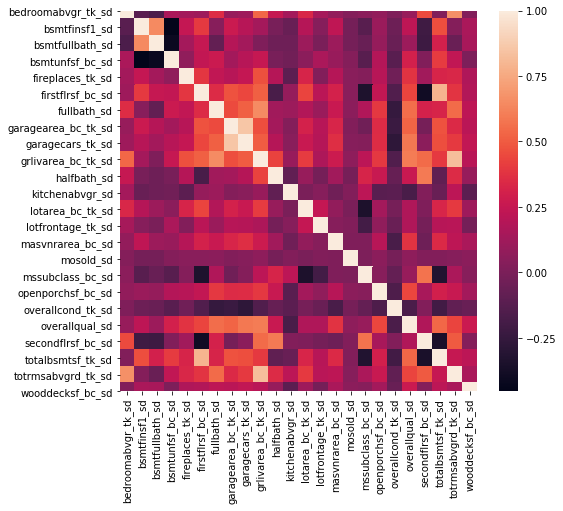

In [60]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_correlated_features, ax=axes)
plt.show()

In [61]:
df_correlated_features.describe().T.sort_values(by='50%')

,count,mean,std,min,25%,50%,75%,max
overallcond_tk_sd,24.0,-0.060264,0.239867,-0.272565,-0.156656,-0.083168,-0.046754,1.0
kitchenabvgr_sd,24.0,0.046953,0.228115,-0.173051,-0.071444,0.011716,0.091011,1.0
mosold_sd,24.0,0.067269,0.200357,-0.020717,0.014108,0.029114,0.051546,1.0
secondflrsf_bc_sd,24.0,0.141562,0.329298,-0.385486,-0.013695,0.030415,0.344585,1.0
mssubclass_bc_sd,24.0,0.058151,0.290207,-0.339507,-0.087876,0.032257,0.167697,1.0
bsmtfullbath_sd,24.0,0.087929,0.279292,-0.407657,-0.057064,0.053148,0.143657,1.0
lotfrontage_tk_sd,24.0,0.123040,0.216552,-0.192306,0.014490,0.090491,0.198864,1.0
bsmtunfsf_bc_sd,24.0,0.113315,0.277325,-0.453010,0.004062,0.118361,0.239527,1.0
bedroomabvgr_tk_sd,24.0,0.193372,0.257756,-0.158706,0.048532,0.119615,0.271295,1.0
bsmtfinsf1_sd,24.0,0.139978,0.293977,-0.453010,-0.025617,0.125372,0.234877,1.0


**Observations:** No values seem that highly correlated with each. The highest mean correlation is below 0.4 and the highest 75%-tile correlation is 0.52.

Inspect variables that are correlated with `'saleprice'`.

In [62]:
df_correlated = df_standardized.corr()

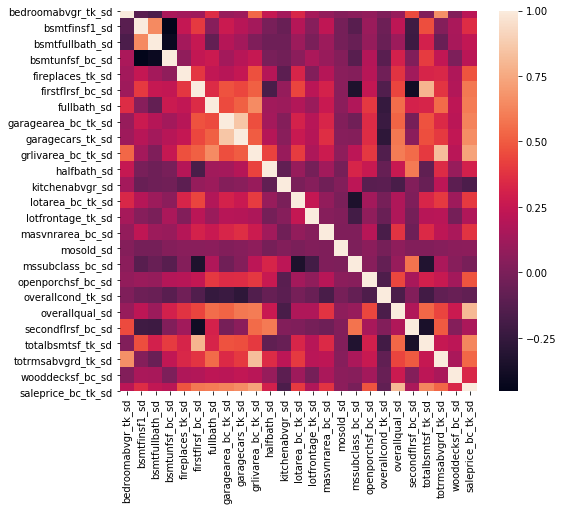

In [63]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_correlated, ax=axes)
plt.show()

In [64]:
df_correlated['saleprice_bc_tk_sd'].sort_values()

kitchenabvgr_sd       -0.159965
overallcond_tk_sd     -0.089710
mssubclass_bc_sd      -0.005622
mosold_sd              0.058573
secondflrsf_bc_sd      0.162788
lotfrontage_tk_sd      0.178699
bsmtunfsf_bc_sd        0.213329
bedroomabvgr_tk_sd     0.213683
bsmtfullbath_sd        0.238419
halfbath_sd            0.303914
wooddecksf_bc_sd       0.331066
bsmtfinsf1_sd          0.353713
masvnrarea_bc_sd       0.381278
lotarea_bc_tk_sd       0.399406
fireplaces_tk_sd       0.479832
openporchsf_bc_sd      0.480807
totrmsabvgrd_tk_sd     0.539419
firstflrsf_bc_sd       0.587466
fullbath_sd            0.597385
garagearea_bc_tk_sd    0.620166
totalbsmtsf_tk_sd      0.634140
garagecars_tk_sd       0.657956
grlivarea_bc_tk_sd     0.728134
overallqual_sd         0.810725
saleprice_bc_tk_sd     1.000000
Name: saleprice_bc_tk_sd, dtype: float64

In [65]:
correlated_with_saleprice = df_correlated['saleprice_bc_tk_sd'].sort_values()

In [66]:
correlated_features = correlated_with_saleprice[correlated_with_saleprice > 0.6].index.tolist()
correlated_features.remove('saleprice_bc_tk_sd')

In [67]:
print(f'Features that have at least a 0.6 correlations with sale price are:\n{correlated_features}')

Features that have at least a 0.6 correlations with sale price are:
['garagearea_bc_tk_sd', 'totalbsmtsf_tk_sd', 'garagecars_tk_sd', 'grlivarea_bc_tk_sd', 'overallqual_sd']


## Model
Now that I have selected the best features, I will create a linear regression model using Scikit-Learn.

In [68]:
model_columns = correlated_features + ['saleprice_bc_tk_sd']
df_model = df_standardized.loc[:, model_columns].copy()

In [69]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1379 entries, 0 to 1378
Data columns (total 6 columns):
garagearea_bc_tk_sd    1379 non-null float64
totalbsmtsf_tk_sd      1379 non-null float64
garagecars_tk_sd       1379 non-null float64
grlivarea_bc_tk_sd     1379 non-null float64
overallqual_sd         1379 non-null float64
saleprice_bc_tk_sd     1379 non-null float64
dtypes: float64(6)
memory usage: 75.4 KB


In [70]:
X = df_model.loc[:, correlated_features]
y = df_model['saleprice_bc_tk_sd']

lrm = linear_model.LinearRegression()

lrm.fit(X, y)

print(f'Coefficients: {lrm.coef_}')
print(f'Intercept: {lrm.intercept_}')

Coefficients: [0.07647727 0.20583181 0.09628892 0.31119974 0.41619647]
Intercept: 2.338781133213957e-14


**Observation:** The intercept is close to zero. The coefficients are between 0.05 and 0.5.

#### Save model dataset
Save the dataset use to create the housing price model to a .csv file.

In [80]:
df_model.to_csv('./housing_price_model.csv')

In [77]:
df_model.corr()

,garagearea_bc_tk_sd,totalbsmtsf_tk_sd,garagecars_tk_sd,grlivarea_bc_tk_sd,overallqual_sd,saleprice_bc_tk_sd
garagearea_bc_tk_sd,1.000000,0.476442,0.855861,0.463766,0.525924,0.620166
totalbsmtsf_tk_sd,0.476442,1.000000,0.461542,0.400205,0.535530,0.634140
garagecars_tk_sd,0.855861,0.461542,1.000000,0.502672,0.588141,0.657956
grlivarea_bc_tk_sd,0.463766,0.400205,0.502672,1.000000,0.602336,0.728134
overallqual_sd,0.525924,0.535530,0.588141,0.602336,1.000000,0.810725
saleprice_bc_tk_sd,0.620166,0.634140,0.657956,0.728134,0.810725,1.000000


In [78]:
lrm.coef_.sum()

1.1059942185645495